# Идентификация сессий ботов по поведенческим признакам

### Проблема

Для предоставления заказчику качественных данных необходимо идентфицировать сессии, генерируемые ботами. Текущий алгоритм bot detection ориентируется на слишком малое множество признаков и выдает результаты, крайне далекие от продвинутых алгоритмов(к примеру Яндекс.Метрика).
Я поставил перед собой задачу улучшить текущий алгоритм.

Итоговая проблема представляет собой задачу бинарной классификации в разрезе бот/не бот

### Данные

Для проведения исследования я взял данные о сессиях с 01.01.2021 по 01.01.2022, а именно 10 000 000 записей, из которых 1 000 000 — сессий, размеченных моими коллегами как сессии ботов, и 9 000 000 других сессий. Для классификации я использовал следуюший набор поведенческих признаков:

* Продолжительность сессии
* Час входа
* Количество посещенных страниц
* Среднее время на странице
* Количиство событий, спровоцированных пользователем(учитиывались только те события, которые триггерятся по клику или скроллингу)
* Среднее время между событиями

К сожалению, многие данные оказались неполными(к примеру в отказных сессиях), и потому итоговый размер выборки скоратился до 3 915 792 записей, из которых 169 547 размечены как записи ботов

#### Загрузка данных

In [146]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

data = pd.read_csv('./bot_data.csv', ',')
data.set_index('session', inplace = True )

data_preproc = data[['session_time','hour','num_page','avg_page_time','num_events','avg_event_time','TARGET']].astype(float)
data_dropped = data_preproc.dropna()
X,y = data_dropped[['session_time','hour','num_page','avg_page_time','num_events','avg_event_time']],data_dropped['TARGET']

#### Предобработка данных

In [149]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
normalizer = preprocessing.StandardScaler()
X_norm = normalizer.fit_transform(X)
train_data, test_data, train_labels, test_labels = train_test_split(
    X_norm,y,
    test_size=0.8,
    random_state=1,
)

### Обучение классификатора

В качестве модели машинного обучения я выбрал алгоритм логистической регрессии. Причины выбора такие:
* Скорость работы(Наиболее интерпретируемый классифкатор метода близжайших соседей у меня обучался больше часа, а предсказания делал за еще неизвестное мне время)
* Интерпретируемость — классификатор строит плоскость, разделяющую все объекты на классы в пространстве признаков

Точность(Accurancy) — вероятно худшая мера качества при дисбалансе классов(классификатор, говорящий, что среди записей нет ботов добьется 95% точности)

In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(class_weight= "balanced")
logreg.fit(train_data, train_labels)
y_pred = logreg.predict(test_data)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_data,test_labels)))


Accuracy of logistic regression classifier on test set: 0.84


Здесь представлена матрица ошибок:

* Верхний левый элемент — количство пользователей, которых наш алгортм правильно разметил как не ботов
* Верхний правый элемент — количество пользователей, которых наш алгоритм разметил как ботов, хотя в исходной выборке они размечены как не боты
* Нижний левый элемент — количество пользователей-ботов, которых наш алгоритм разметил как не ботов
* Нижний правый элемент — количество пользователей—ботов, размеченных алгоритмом как ботов

In [156]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_labels, y_pred)
print(confusion_matrix)

[[2496426  500672]
 [   3569  131967]]


#### Отчет о классификации 

Разберем подробнее, что здесь написано:

* precision — доля объектов, названных классификатором положительно и при этом действительно являющихся положительными
* recall — доля объектов положительного класса, найденных алгоритмом


In [161]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred, target_names = ['not bot','bot']))

              precision    recall  f1-score   support

     not bot       1.00      0.83      0.91   2997098
         bot       0.21      0.97      0.34    135536

    accuracy                           0.84   3132634
   macro avg       0.60      0.90      0.63   3132634
weighted avg       0.96      0.84      0.88   3132634



#### ROC-кривая

Эта кривая строится в координатах (TRP,FRP). Наша задача — максимизировать TRP, минимизиуря FRP. Таким образом качество алгоритма оценивается как площадь под графиком(чем ближе график к левому верхнему углу, тем лучше!) 

Красной пунктирной линией на графике обозначена ROC-кривая классификатора, случайным образом выдающего метки классов

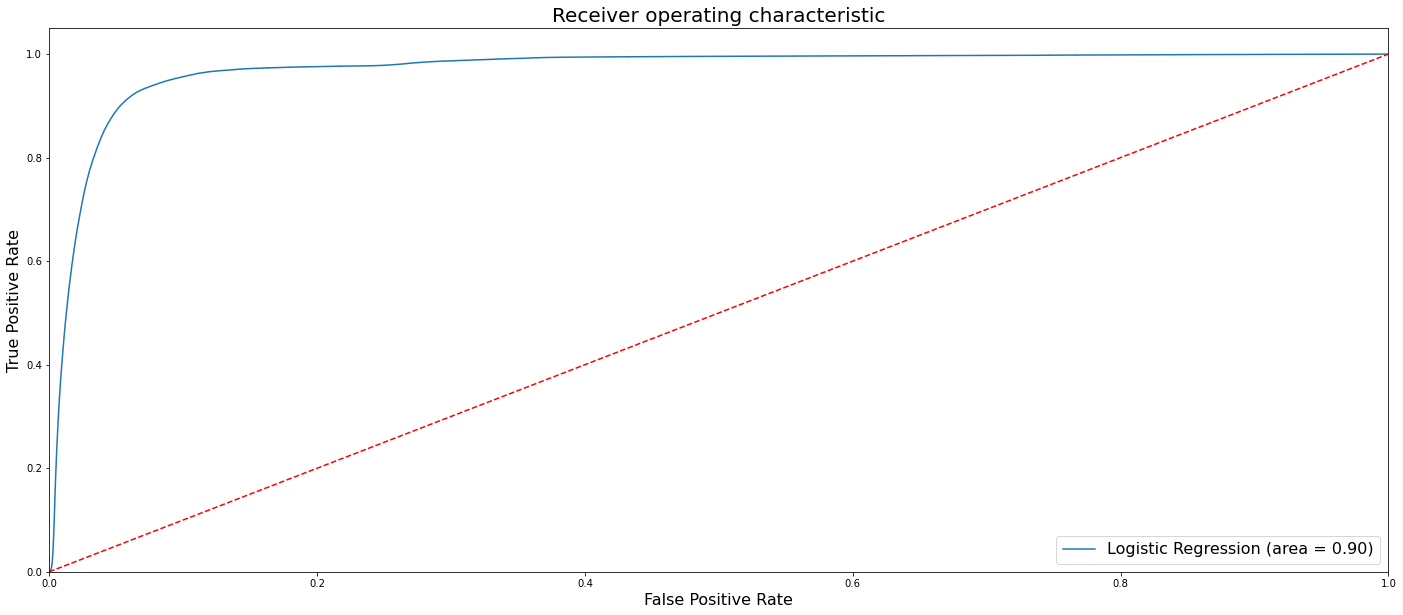

In [160]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(test_labels, logreg.predict(test_data))
fpr, tpr, thresholds = roc_curve(test_labels, logreg.predict_proba(test_data)[:,1])
plt.figure(figsize= (24,10)) 
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('Log_ROC')
plt.show()

### Вывод

Алгоритм показал крайне достойный результат, сумев правильно выделить 97.5% заранее размеченных ботов и по поведенческим признакм выделить около 500 000 новых бот-записей.

### Дальнейшее развитие

1. Переписать модель на pytorch для увеличения скорости работы
2. Добавить еще признаков для улучшения качества классификации
3. Написать набор заготовленных скриптов для того, чтобы результаты работы модели можно было добавить в daily routine веб-аналитики
3. В течение текущего года написать новый алгоритм на основе нейросетей
